In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter

In [122]:
# make dataset

transform = transforms.Compose([
    # transforms.Grayscale(),
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms.Normalize(mean=[0.5], std=[0.2])
])
dataset = datasets.ImageFolder(root='./archive-2/', transform=transform)
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size

# train_data = datasets.ImageFolder(root='./child-adult/train', transform=transform)
# test_data = datasets.ImageFolder(root='./child-adult/test', transform=transform)

train_data, test_data = random_split(dataset, [train_size, test_size])
dataset.classes


['no', 'yes']

In [123]:
train = DataLoader(train_data, batch_size=10, shuffle=True)
test = DataLoader(test_data, batch_size=10, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


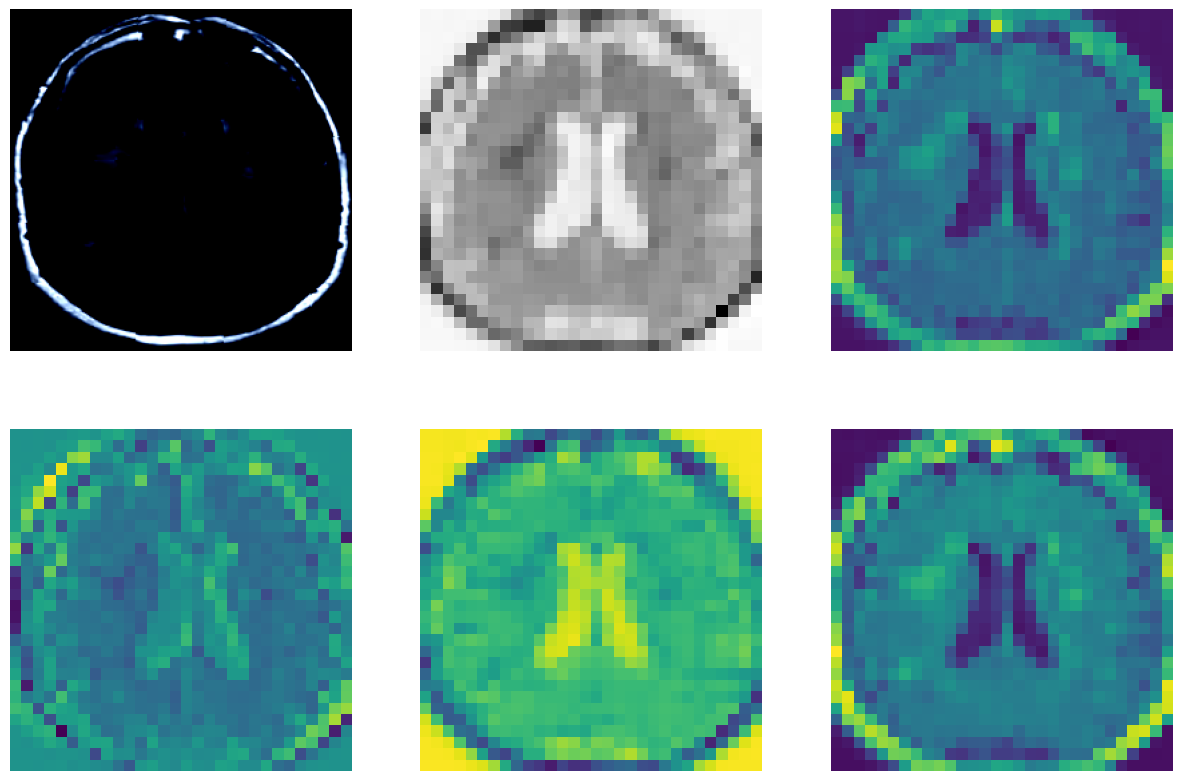

0

In [124]:
import random
num = random.randint(1,500)

for i, (x_train, y_train) in enumerate(train_data):
    if i  == num:
        break
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)

x = x_train
x = conv1(x)
x = F.max_pool2d(x,2,2)
x = conv2(x)
x = F.max_pool2d(x,2,2)
x = conv3(x)
x = F.max_pool2d(x,2,2)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0][0].imshow(x_train.permute(1,2,0))
ax[0][0].axis('off')

ax[0][1].imshow(x.detach().numpy()[0],cmap='gray')
ax[0][1].axis('off')

ax[0][2].imshow(x.detach().numpy()[1])
ax[0][2].axis('off')

ax[1][0].imshow(x.detach().numpy()[2])
ax[1][0].axis('off')

ax[1][1].imshow(x.detach().numpy()[3])
ax[1][1].axis('off')

ax[1][2].imshow(x.detach().numpy()[4])
ax[1][2].axis('off')

plt.show()
y_train

In [125]:
class Faces(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,  kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)

        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)

        self.dropout = nn.Dropout(0.5)


        #FCNN
        self.fc1 = nn.Linear(32*30*30, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 10)
        # self.fc5 = nn.Linear(10, 4)
        self.fc6 = nn.Linear(10, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        # x = F.max_pool2d(x, 2, 2)

        #flattening x befor fully connected layers
        x = x.view(x.size(0),-1)

        #fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x))
        # x = self.dropout(x)
        x = self.fc6(x)
        return x

In [126]:
# torch.manual_seed(41)
model = Faces()
model

Faces(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=28800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=2, bias=True)
)

In [127]:
#loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=1e-5)
torch.manual_seed(41)

In [128]:
train_loss_writer = SummaryWriter('./run/train_loss')
test_loss_writer = SummaryWriter('./run/test_loss')
train_accuracy_writer = SummaryWriter('./run/train_accuracy')
test_accuracy_writer = SummaryWriter('./run/test_accuracy')
count = 0

In [129]:
import time

start = time.time()

epochs = 30
loss_train = []
loss_test = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    running_train_loss = 0.0  
    running_test_loss = 0.0   

    model.train()
    for b, (x_train, y_train) in enumerate(train):
        b+=1
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum().item()  
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() 
        

        if b % 1 == 0:
            print(f'Epoch: {epoch+1}, Batch: {b}, Loss: {loss.item()}')
    loss_train.append(running_train_loss / len(train))  
    train_correct.append(trn_corr / len(train.dataset))

    
    
    


    model.eval()  
    with torch.no_grad():  
        for b, (x_test, y_test) in enumerate(test):
            y_val = model(x_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum().item()  
            
            loss = criterion(y_val, y_test)
            running_test_loss += loss.item()  
    
    
    avg_test_loss = running_test_loss / len(test)
    
    
    loss_test.append(avg_test_loss)  # Average test loss
    test_correct.append(tst_corr / len(test.dataset))  # Accuracy as a percentage
    print(f'TEST accuracy:{(tst_corr / len(test.dataset))*100}% TRAIN accuracy: {(trn_corr / len(train.dataset))*100}%')
    print(f'TEST LOSS: {avg_test_loss}, TRAIN LOSS: {running_train_loss / len(train)}')

    train_loss_writer.add_scalar('Train_loss', (running_train_loss / len(train)), count)
    test_loss_writer.add_scalar('test loss', avg_test_loss, count)
    train_accuracy_writer.add_scalar('train accuracy', (trn_corr / len(train.dataset)), count)
    test_accuracy_writer.add_scalar('test accuracy', (tst_corr / len(test.dataset)), count)
    count+=1
    

# Print total training time
total_time = time.time() - start
print(f"Training took: {total_time/60:.2f} minutes!")




Epoch: 1, Batch: 1, Loss: 0.7216227650642395
Epoch: 1, Batch: 2, Loss: 0.5905461311340332
Epoch: 1, Batch: 3, Loss: 1.388007402420044
Epoch: 1, Batch: 4, Loss: 0.5490582585334778
Epoch: 1, Batch: 5, Loss: 0.6078563928604126
Epoch: 1, Batch: 6, Loss: 0.6972989439964294
Epoch: 1, Batch: 7, Loss: 0.5795577764511108
Epoch: 1, Batch: 8, Loss: 0.6324306726455688
Epoch: 1, Batch: 9, Loss: 0.5890099406242371
Epoch: 1, Batch: 10, Loss: 0.5691777467727661
Epoch: 1, Batch: 11, Loss: 0.640020489692688
Epoch: 1, Batch: 12, Loss: 0.575244665145874
Epoch: 1, Batch: 13, Loss: 0.45537203550338745
Epoch: 1, Batch: 14, Loss: 0.5497134923934937
Epoch: 1, Batch: 15, Loss: 0.744279682636261
Epoch: 1, Batch: 16, Loss: 0.4649959206581116
Epoch: 1, Batch: 17, Loss: 0.4195740520954132
TEST accuracy:63.41463414634146% TRAIN accuracy: 67.08074534161491%
TEST LOSS: 0.5871910274028778, TRAIN LOSS: 0.633750962860444
Epoch: 2, Batch: 1, Loss: 0.9465917348861694
Epoch: 2, Batch: 2, Loss: 0.35642728209495544
Epoch: 2, 

Text(0.5, 1.0, 'Loss')

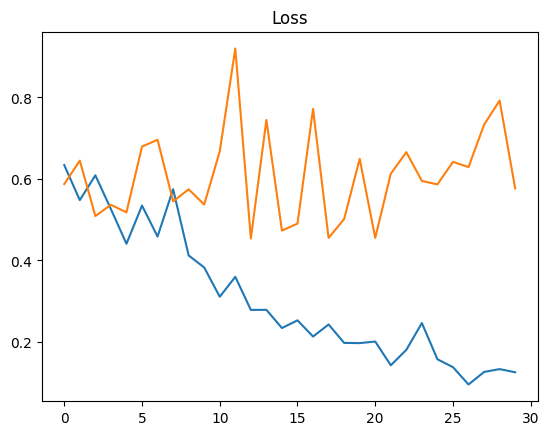

In [152]:
# Plot train and test loss on the first subplot
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.title('Loss')




(0.0, 100.0)

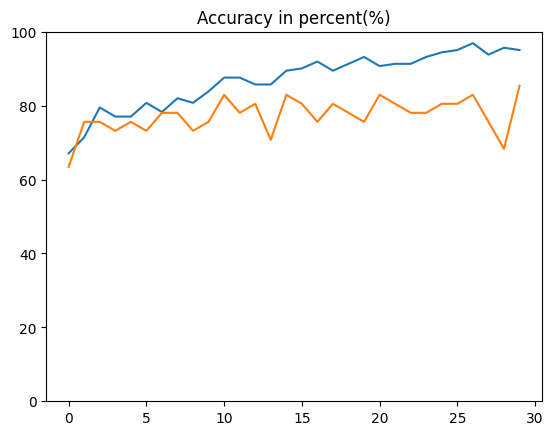

In [158]:
# Plot train and test accuracy on the second subplot
plt.plot([i*100 for i in train_correct], label='Train Accuracy')
plt.plot([i*100 for i in test_correct], label='Test Accuracy')
plt.title('Accuracy in percent(%)')
plt.ylim(0,100)

In [136]:
import os
import random 
num = random.randint(1,100)

# Load the image and preprocess it
url = './archive-2/yes'
url_unseen = './apk/pne3.jpg'
count = 0
model.eval()
for i, image in enumerate(os.listdir(url)):
    url_unseen = f'{url}/{image}'
    with Image.open(url_unseen) as imga:
        if imga.mode != 'RGB':
            imga = imga.convert('RGB')
        # plt.imshow(img)
        img = transform(imga).view((1,3,256,256))
        # plt.imshow(img.reshape(3,224,224).permute(1,2,0))

    # Get the model output (logits)
        with torch.no_grad():
            res = model(img)
            
        # Apply softmax to get probabilities
        probs = torch.softmax(res, dim=1)

        # Get the index of the highest probability
        predicted_class = torch.argmax(probs, dim=1).item()
        classes = dataset.classes

        # if int(probs[0][0]*100) < int(probs[0][1]*100) and i not in l and int(probs[0][1]*100)>80:
        # fig, ax = plt.subplots(1,2, figsize=(5,10))
        # print(f'{classes[0]}: {int(probs[0][0]*100)}% \n{classes[1]}: {int(probs[0][1]*100)}%')
        if probs[0][0]>probs[0][1]:
            print(url_unseen)
            print(f'{probs[0][0]} , {probs[0][1]}')
            count+=1
        # ax[0].imshow(imga)
        # ax[1].imshow(img.reshape(3,256,256).permute(1,2,0))
        # plt.show()
print(f'{(count/len(os.listdir(url)))*100}%')
        


./archive-2/yes/Y194.jpg
0.9294411540031433 , 0.07055884599685669
./archive-2/yes/Y78.jpg
0.775900661945343 , 0.2240993082523346
./archive-2/yes/Y187.jpg
0.6261610388755798 , 0.37383899092674255
./archive-2/yes/Y18.JPG
0.8985198140144348 , 0.10148012638092041
./archive-2/yes/Y114.JPG
0.9830231070518494 , 0.016976872459053993
4.9504950495049505%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


yes


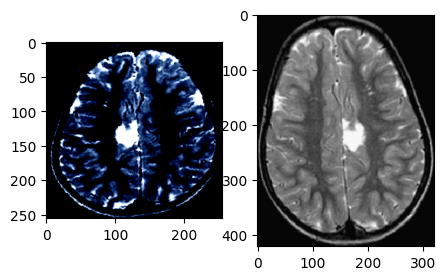

In [147]:
single_url = './checking/yes4.jpg'

model.eval()
with Image.open(single_url)as image:
    if image.mode != 'RGB':
        image = image.convert('RGB')
    img = transform(image).view((1,3,256,256))
with torch.no_grad():
    pred = model(img)
    pred = torch.softmax(pred, dim=1)
    print(dataset.classes[0]) if pred[0][0]>pred[0][1] else print(dataset.classes[1])
    fig, ax = plt.subplots(1,2, figsize = (5,10))
    ax[0].imshow(img[0].permute((1,2,0)))
    ax[1].imshow(image)

    plt.show()




In [133]:
#loading model
torch.save(model.state_dict(), './BrainTumorCNN.pt')

In [134]:
print(bool(0))

False
